### Google Play Review Crawling

In [148]:
# ! pip install google-play-scraper
import pandas as pd
from google_play_scraper import Sort, reviews

pd.set_option('display.max_colwidth', 500) 
pd.options.display.colheader_justify = 'left'

References
- https://github.com/JoMingyu/google-play-scraper
- https://simbbo-blog.tistory.com/190

In [2]:
# 최대 크롤링 리뷰 횟수 지정
count_per_request = 5000

# 크롤링 실행
result, continuation_token = reviews(
    'com.netmarble.tskgb'
    , lang = 'ko'
    , country = 'kr'
    , sort = Sort.NEWEST
    , count=count_per_request
)

In [3]:
# 빈 리스트 정의
reviewId_list = []
userName_list = []
content_list = []
score_list = []
thumsUpCount_list = []
at_list = []
replyContent_list = []

In [ ]:
# 필요한 부분만 데이터프레임화
for i in range(0, len(result)):
    reviewId_list.append(result[i]['reviewId'])
    userName_list.append(result[i]['userName'])
    content_list.append(result[i]['content'])
    score_list.append(result[i]['score'])
    thumsUpCount_list.append(result[i]['thumbsUpCount'])
    at_list.append(result[i]['at'])
    replyContent_list.append(result[i]['replyContent'])

data = {
    'reviewId':reviewId_list
    , 'userName':userName_list
    , 'content':content_list
    , 'score':score_list
    , 'thumbsUpCount':thumsUpCount_list
    , 'at':at_list
    , 'replyContent':replyContent_list
}

df = pd.DataFrame(data)

In [146]:
# 크롤링 결과 확인
print('='*70)
display(df.head(3))
print('='*70)
df.info()

,reviewId,userName,content,score,thumbsUpCount,at,replyContent
0,ac71b9e8-5c78-47b8-bdbc-ef05d2ae116f,Google 사용자,"머 할라고 하면 계속 튕김. 스테이지 넘어가다 튕김, 로비에서 머 할라고 하면 튕김 정상적인 게임진행이 힘듬 25년에 나온게임이라고 생각이 안듬",1,0,2025-05-26 12:52:45,None
1,a0bfccfe-3127-4b20-b294-1dca226921a1,Google 사용자,무과금도 어느정도 플레이 하게 만들어야 하는데 아예 진행하기도 힘드네요 이러다간 과금러들만 남고 다 떠날듯요,1,0,2025-05-26 12:47:29,None
2,d8aa581f-569b-4287-8680-90d620134e1e,Google 사용자,뽑기 확률 봐라ㅋㅋㅋ 할 말이 없네,1,0,2025-05-26 12:46:10,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reviewId       3269 non-null   object        
 1   userName       3269 non-null   object        
 2   content        3269 non-null   object        
 3   score          3269 non-null   int64         
 4   thumbsUpCount  3269 non-null   int64         
 5   at             3269 non-null   datetime64[ns]
 6   replyContent   2047 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 178.9+ KB


### Text Preprocessing

Reference
- https://github.com/bab2min/kiwipiepy
- https://youtu.be/llfvObDLp64?si=cBBVTEGI65TrFP2v

In [9]:
# ! pip install kiwipiepy
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

In [10]:
# 객체 지정
kiwi = Kiwi()
stopwords = Stopwords()

In [11]:
# 전처리용 데이터프레임 정의
processed_reviews = df[['content']].rename(columns={'content':'original_contents'})

In [48]:
# 각 리뷰를 토큰 리스트로 변환
tokenized_contents_list = []

for i in range(0, len(processed_reviews['original_contents'])):
    tokenized_content = kiwi.tokenize(
        processed_reviews.loc[i]['original_contents']
        , normalize_coda=True
        , stopwords=stopwords
        )
    # tokenized_contents_list 안에 각 리뷰별 token들을 모아둔 리스트가 들어감
    tokenized_contents_list.append(tokenized_content)   

In [49]:
# 토근 리스트를 원본 리뷰와 붙이기
processed_reviews['tokens'] = None

for i in range(0, len(tokenized_contents_list)):
    token_list = []
    for j in range(0, len(tokenized_contents_list[i])):
        # print(tokenized_contents_list[i][j].form)
        token_list.append(tokenized_contents_list[i][j].form)
    # print(token_list)
    processed_reviews.at[i, 'tokens']= token_list

processed_reviews.tail()

,original_contents,tokens
3264,우효 다운받는당,"[우효, 다운, 받, 는다, ᆼ]"
3265,레전드 상황 발생,"[레전드, 상황, 발생]"
3266,굿,[굿]
3267,추억의 게임이 돌아왔다,"[추억, 게임, 돌아오]"
3268,나이스,[나이스]


### LDA (: Latent Dirichlet Allocation)

#### (1) 필요한 라이브러리 설치 및 임포트

In [65]:
# ! pip install gensim pyldavis
import numpy as np
import matplotlib.pyplot as plt

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings

# pyLDAvis 사용에 DeprecationWarning 오류 무시
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### (2) 데이터 준비

In [67]:
processed_reviews.head(5)

,original_contents,tokens
0,"머 할라고 하면 계속 튕김. 스테이지 넘어가다 튕김, 로비에서 머 할라고 하면 튕김...","[머, ᆯ라고, 계속, 튕기, ᆷ, 스테이지, 넘어가, 튕기, ᆷ, 로비, 머, ᆯ..."
1,무과금도 어느정도 플레이 하게 만들어야 하는데 아예 진행하기도 힘드네요 이러다간 과...,"[무, 과금, 어느, 정도, 플레이, 만들, 는데, 아예, 진행, 힘들, 네요, 이..."
2,뽑기 확률 봐라ㅋㅋㅋ 할 말이 없네,"[뽑기, 확률, 어라, 네]"
3,"열쇠 빨리 소모돼 무과금, 소과금에게는 즐기는데에 불편 느낄수 있는데 세나1 처럼 ...","[열쇠, 빨리, 소모, 무, 과금, 소, 과금, 즐기, 데, 불편, 느끼, 는데, ..."
4,일딴 이겜은 운영자체를 안함 1주일전에 6성 크리스 없어졌다고 문의했는데 아직 문의...,"[일, 따, ᆷ, 운영, 자체, 안, ᆷ, 1, 주일, 전, 6, 성, 크리스, 문..."


#### (3) 사전(Dictionary)과 말뭉치(Corpus) 생성

In [125]:
# 토큰 리스트로부터 Dictionary 생성
dictionary = corpora.Dictionary(processed_reviews['tokens'])

# 너무 희귀하거나 너무 흔한 단어 제거
dictionary.filter_extremes(no_below=5, no_above=0.8)

print(f"사전에 포함된 고유 단어 개수: {len(dictionary)}")

# 토큰 리스트를 BoW(Bag-of-Words) 형태로 변환하여 말뭉치(Corpus) 생성
corpus = [dictionary.doc2bow(doc) for doc in processed_reviews['tokens']]

print(f"생성된 말뭉치의 문서 개수: {len(corpus)}")
# 첫 번째 문서의 BoW 표현 확인 (예시)
print("첫 번째 문서의 BoW 표현:", corpus[0])
print("\n")


사전에 포함된 고유 단어 개수: 1504
생성된 말뭉치의 문서 개수: 3269
첫 번째 문서의 BoW 표현: [(0, 1), (1, 2), (2, 3), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1)]




#### (4) 최적의 토픽 수 찾기

In [126]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    여러 개의 토픽 수에 대해 coherence 값을 계산하는 함수
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

# 여러 토픽 수에 대한 coherence 값 계산
print("다양한 토픽 수에 대한 coherence 값 계산 중...")
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=processed_reviews['tokens'], 
                                                        start=2, limit=20, step=2)

다양한 토픽 수에 대한 coherence 값 계산 중...


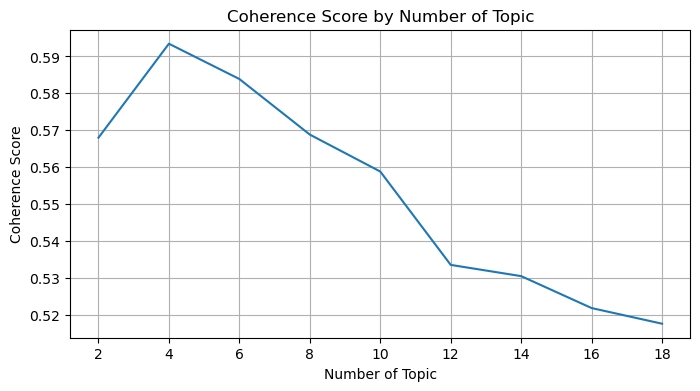

최적의 토픽 수: 4


In [127]:
# 최적의 토픽 수 시각화
limit=20
start=2
step=2
x = range(start, limit, step)
plt.figure(figsize=(8, 4))
plt.plot(x, coherence_values)
plt.xlabel("Number of Topic")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topic")
plt.xticks(x)
plt.grid(True)
plt.show()

# 최적의 토픽 수 확인
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f'최적의 토픽 수: {optimal_num_topics}')


#### (5) LDA 모델 학습

In [104]:
# 토픽 수 별도 지정
optimal_num_topics = 8

In [128]:
# 앞서 찾은 최적의 토픽 수로 LDA 모델 학습
print(f"LDA 모델 학습 시작 (토픽 수: {optimal_num_topics})...")
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)
print("LDA 모델 학습 완료.")
print("\n")

LDA 모델 학습 시작 (토픽 수: 4)...
LDA 모델 학습 완료.




#### (6) 토픽 분석

In [129]:
# 학습된 LDA 모델의 토픽 확인
print("LDA 모델 결과 - 각 토픽별 상위 단어:")
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"토픽 {idx+1}: {topic}")
print("\n")

LDA 모델 결과 - 각 토픽별 상위 단어:
토픽 1: 0.055*"게임" + 0.055*"ᆷ" + 0.038*"거" + 0.033*"안" + 0.026*"는데" + 0.022*"음" + 0.021*"너무" + 0.017*"어요" + 0.016*"발열" + 0.015*"ᆫ데" + 0.012*"그냥" + 0.012*"네" + 0.010*"뭐" + 0.010*"좀" + 0.010*"못"
토픽 2: 0.050*"나" + 0.034*"좋" + 0.033*"세" + 0.032*"네요" + 0.030*"ᆸ니다" + 0.030*"습니다" + 0.023*"추억" + 0.019*"기대" + 0.017*"있" + 0.017*"재밌" + 0.015*"옛날" + 0.014*"어요" + 0.013*"세븐나이츠" + 0.012*"생각" + 0.012*"잘"
토픽 3: 0.058*"접속" + 0.047*"재" + 0.041*"튕기" + 0.038*"계속" + 0.026*"ᆸ니다" + 0.024*"뜨" + 0.018*"세요" + 0.016*"로딩" + 0.016*"다가" + 0.016*"자꾸" + 0.014*"네요" + 0.013*"좀" + 0.013*"들어가" + 0.013*"라고" + 0.012*"시"
토픽 4: 0.023*"1" + 0.020*"캐릭터" + 0.018*"스킬" + 0.015*"개" + 0.015*"보다" + 0.014*"냐" + 0.013*"3" + 0.012*"2" + 0.011*"주" + 0.010*"이상" + 0.010*"과금" + 0.010*"쓰" + 0.010*"쫄작" + 0.010*"별로" + 0.009*"확률"




#### (7) LDA 결과 시각화 (pyLDAvis)

In [130]:
# pyLDAvis를 위한 준비
print("pyLDAvis 시각화 준비 중...")
vis = gensimvis.prepare(lda_model, corpus, dictionary)
print("pyLDAvis 시각화 준비 완료.")

# 시각화 결과를 HTML 파일로 저장
pyLDAvis.save_html(vis, f'lda_visualization_{optimal_num_topics}.html')
print("시각화 결과가 html 파일로 저장되었습니다.")
print("\n")

pyLDAvis 시각화 준비 중...
pyLDAvis 시각화 준비 완료.
시각화 결과가 html 파일로 저장되었습니다.




#### (8) 각 리뷰의 토픽 할당

데이터프레임에 지배적인 토픽 정보 추가 완료.
                                                                                                                                                                                                                                                                                                                                                tokens  \
0                                                                                                                                                                                                                                                     [머, ᆯ라고, 계속, 튕기, ᆷ, 스테이지, 넘어가, 튕기, ᆷ, 로비, 머, ᆯ라고, 튕기, ᆷ, 정상, 게임, 진행, 힘듬, 25, 나오, 게임, 라고, 생각, 안듬]   
1                                                                                                                                                                                                                                                                            [무, 과금, 어느, 정

<Figure size 1200x600 with 0 Axes>

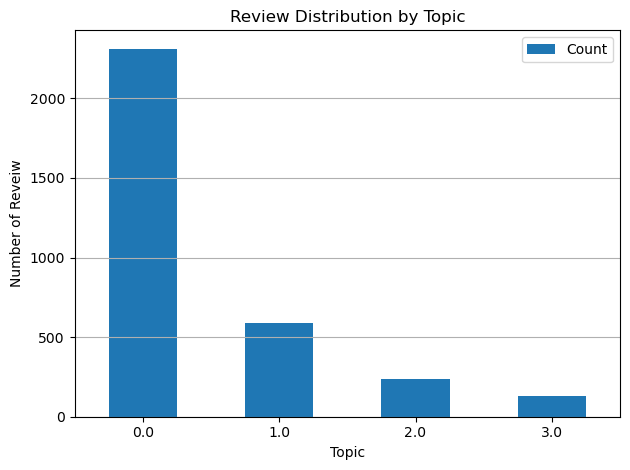

In [131]:
# 각 리뷰의 가장 확률 높은(지배적인) 토픽을 데이터프레임에 추가
def get_dominant_topic(lda_model, bow_vector):
    """BoW 벡터를 입력받아 해당 문서의 지배적인 토픽과 확률을 반환하는 함수"""
    # 문서의 토픽 분포 가져옴
    topic_distribution = lda_model.get_document_topics(bow_vector)
    
    # 확률이 가장 높은 토픽 지정
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    
    # (토픽 ID, 확률) 튜플을 반환
    return dominant_topic[0], dominant_topic[1]

# 모든 리뷰에 대해 지배적인 토픽을 찾아 데이터프레임에 추가
processed_reviews[['dominant_topic', 'topic_probability']] = processed_reviews['tokens'].apply(
    lambda tokens: pd.Series(get_dominant_topic(lda_model, dictionary.doc2bow(tokens)))
)

print("데이터프레임에 지배적인 토픽 정보 추가 완료.")
print(processed_reviews[['tokens', 'dominant_topic', 'topic_probability']].head())

# 토픽별 리뷰 수 확인
topic_counts = processed_reviews['dominant_topic'].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Count']
print("\nNuber of Reveiw by Topic:")
print(topic_counts)

# 토픽 분포 시각화
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', x='Topic', y='Count')
plt.title('Review Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Reveiw')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### (9) 토픽별 대표 리뷰 추출

In [156]:
for topic in range(optimal_num_topics):
    # 토픽별 확률 상위 리뷰 추출
    top_reviews = processed_reviews[processed_reviews['dominant_topic'] == topic].sort_values('topic_probability', ascending=False).head(5)
    print("="*100, "\n", f"Topic Cluster: {topic}")
    display(top_reviews['original_contents'])

 Topic Cluster: 0


2578    24 울트라 최고 사양 : 버벅임 심함, 발열 심함 고 사양 : 버벅임 있음, 발열 심함 중 사양 : 버벅임 간헐적 있음, 발열 심함 저사양 : 발열 있음 모니터 연결 시 최고사양 : 버벅임 매우 심함, 발열 있음 고사양 : 버벅임 심함, 발열 있음 중 사양 : 버벅임 있음, 발열 있음 저 사양 : 버벅임 있음, 발열 있음 쿨링 패드 사용은 미실시 이 게임을 모바일로 하는 것은 무리가 있음 쿨링 패드가 필연적일 거 같음 모니터 연결의 경우 덱스의 문제로 여겨짐
780                                                                                                                                                                                                                 렉 너무 심하네요 손 올라갈거같아요 ㅎㅎ 네 ? 렉 심하다고요 개 빡치네 진짜 현질도하기 시작했는데
2982                                                                                                                                                                                                              s25울트라 쓰는데 최저사양으로 해도 발열이 너무 심해요. 추억 때문에 받아봤는데 이건 좀 아닌거같음.
2315                                                                                                                                                                                                

 Topic Cluster: 1


21                                                                                                                                                                                                                                                                                                            세나원작을 안해본 입장에서도 12일차 현재 아주 재밌게 즐기고 있습니다. 다만 과금요소가 상당히 많은 부분이 걱정입니다. 과금에따른 유저 스펙차이는 분명히 있어야겠지만 월정액정도만 꾸준히 결제하는 유저도 재밌게 즐길수 있는 갓겜으로 운영해주셨으면 좋겠습니다.
971     옛날에 세나를하면서 느꼈던 감정을 다시느낄수 있어 정말 즐겁게 플레이하고있습니다 유저들의 의견을 적극반영하며 노력하는 모습을 보면 잘운영해줄거라 믿기에 몇가지 바라는점을 적어봅니다 1.옛날에 있었던 시스템들이 많이 돌아오면 좋겠습니다 체스판,도감영웅관계도이런것들이요 2.캐릭마다의 개성이 초창기만큼강화되길 바랍니다 손오공의 분신,카일의피해전가,루리소멸등등 세븐나이츠의 재미요소중하나 였어서 기억에 많이 남네요 3.개인적인 바램입니다만 최종단계가 각성까지면 좋겠습니다 신화각성이라는 시스템으로 인해 밸런스가 많이 망가졌었고 캐릭터육성에 대한피로도 매우컸던걸로 기억납니다 쓸캐릭터만 쓰게되는등 부작용도 많았고요 신화각성만큼은 추가에 신중을 가해주시길부탁드립니다 추가되는 순간 되돌릴수없으니까요. 세나만큼이나 온갖감정을 다느끼며 하는 게임도 없는것같습니다 부디이번엔 오래갑시다 화이팅입니다
1223                                                                                                      

 Topic Cluster: 2


1940                                                               모험 들어가려고하면 무한 로딩임.. +모험을 들어가려고 모험을 클릭하거나, 결투장을 이용하기 위해 결투장을 클릭하면 게임이 멈추고, 튕겨버립니다. +한번 나갔다가 들어오면 계속 재접속이 필요하다는 문구만 뜨고 게임 접속이 아예 안됩니다.
937                                                                                                                                                                               재접속재접속재접속재접속재접속재접속재접속
351                                                                                                      '결투장 로딩화면에서 멈추는 현상' 좀 고쳐주세요. 그리고 그로인해 사라진 결투장 티켓, 깎인 점수도 배상해주세요. 배상이 불가능하다면 그에 맞는 대처 부탁드립니다...
1916                                                                                                                            아 뭔 허구한날 재접속 하라고 뜹니까.. 잠깐 나갔다오면 재접속뜨고 화면이동하면 재접속 뜨고 PC로해도 재접속 뜨고 뭐예요 이게
1663    게임 접속하면 재접속 필요함이라고 메인화면으로 나가지다가 운좋아야 접속되는 느낌이네요. 매접속 한 3-4번은 계속 나가지는 것 같아요. 수정부탁드립니다. +2025.5.18 게임 접속 후 모험돌다가 앱이 강제종료 되거나, 게임 재접속 하여도 재접속이 필요하다는 문구만 계속 뜨네요 . 최적화가 너무 안되어 있는 것 같습니다. 확인부탁드립니다.


 Topic Cluster: 3


1487                                                                                                                              쓰레기 오브 쓰레기 전형적인 간판 갈아 끼우고 한탕하자 가격만 올려서 재출시 누가 여기에 돈쓰냐 바뀐게 1도 없이 돈써라 하고 출시하면 누가 돈 씀 별점 한개도 아깝다
721                                                                                                                                                                                      적은 보상 자동전투 노가다 개 노잼 중국산 양산형 게임보다 못한 수준
2265                                                                                                                                                                                             픽업캐 어차피 초월할텐데 반천장까지 넣었어야했나요..?
307     겜이 옛날거랑비교하면 1퀄이괜찮 2근데 예전에는 열쇠랑루피 뽑기권을 어느정도 많이줬는데 여긴쓸데없는4성을 출석이벤트로줌 3거의 뽑기위주로 뽑기권뿌리고루비나열쇠써서 루비얻고 뽑기로 거읬는건데 여긴 4뽑기보고 개답없음 예전뽑은 10개중 마지막한장은4성이상캐릭줌 그리고5성뽑도 잘나오고 근데여긴 3성만 나오지과금아니면 천장노려야지 거의. 뽑이 이상태면 거의살아남기힘듭 스토리등 어디가 좋아야
1336                                                                                                    

In [157]:
for topic in range(optimal_num_topics):
    # 토픽별 랜덤 추출
    top_reviews = processed_reviews[processed_reviews['dominant_topic'] == topic].sample(5)
    print("="*100, "\n", f"Topic Cluster: {topic}")
    display(top_reviews['original_contents'])

 Topic Cluster: 0


1510    너무 심각하다 쫄짝을 돌려놓으면 그 거지같은 사버장애 때문에 멈추고 심지어 5번을 다시 재접해야 고쳐지는 서버문제 대체 누가 진화재료를 이렇게 희귀, 전설 다 똑같이 만들어 놨냐? 소모는 전설이 지금처럼 50개 먹는건 이해 하는데 5성진화 재료 500개를 갈아야 6성 진화를 시킬 수 있게 만들어 놓은놈은 진짜 개념이 없다 그것도 사용처도 많고 많이 사용하는 희귀 영웅들에게 까지도 똑같이 적용하니 애들이 진화를 못함... 이게맞나? 뽑기는 뭔 200뽑을 쳐 해야지 1개를 확정으로 비틱하게 만들어놨냐 심지어 초월까지 있는데 이건 진짜 핵과금러를 위한게 아닌가 싶을정도로 심한 픽업창 도대체 누구를 위한 세나냐? 추억 하나만으로 우리가 이런걸 이해해줄꺼라 믿은 개발진들은 진짜 다시한번 게임을 만들때 생각을 하고 충분한 테스트를 거치고 유저가 불편하지 않을 정도로 손해를 본다는 생각을 안들게끔 고려를 최대한 해서 만들어야 하는거 아닌가? 중학교 시절 정말 재미있게 했던 게임인데 실망이 크다
494                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 발열이 심해서 

 Topic Cluster: 1


1319                                                                                                                                                                        리뷰 수정합니다. 게임 너무 훌륭해요! 옛날 세나1 리부트가 만약 성공했다면 지금 모습이지 않았을까 싶네요 대부분 영웅들이 활용 가능하고 여러가지 캐릭터 써보면서 결투장 하는게 세나 매력이라고 생각합니다. 쫄작때문에 무과금도 시간만 투자하면 무환소환이 가능하다는게 이미 수집형 게임의 최고시스템입니다.
2585                                                                                                                                                                                                                                                                                                                 개인적으로 전반적으로 기존 버전 보다 별로 인듯 합니다.
1739                                                                                                                                                                                                                   세나 1 초기부터 6년동안 했고 길드도 운영했던 유저입니다 운영때문에 많이 실망해서 접었었는데 이번에 리버스 나와서 정말 기뻐요 세나 1 처럼 급격한 메타변화와 괴랄한 과금유도만 피하면

 Topic Cluster: 2


2422                                                                         게임 재밌어요 근데 쫄작 자동전투 서버장애땜에 안된다는데 이거 빠르게 개선 부탁드립니다
1365    아니 게임을 켜면 걸핏하면 재접속하라 그러고 또 로비창 들어가도 재시작하라 그러고 당최 게임을 정상적으로 즐길 수가 없음 그리고 자주 튕기고 BM만 빨아먹을 생각하지 말고 이런것들 좀 우선적으로 개선좀 하시죠?
1416                                                                             쫄작 돌릴때 서버오류가 자주 뜹니다 그리고 재접속이 계속 되구요 확인 부탁드려요
2868                                                                                                             재접속 무한 로딩 떠요
225                                                                                                              결투장하는데 자꾸 튕김
Name: original_contents, dtype: object

 Topic Cluster: 3


2262                                                     캐릭터 음성이 되게 울리듯 들린다나 에반이 되게 심한거 같아요 다른캐릭터들도 그렇고 전체적으로 완성도가 아쉽네요. 그리고 캐릭터 모델링도 너무 카툰에 집중해서 그런가 뭉개지는게 심해요 옛날에 정말 재밌게 했어서 기대했는데..
1972                                                                                                                재미는 있는데 어째 기존 세나보다 전체적으로 퀄이 더 떨어진것같고 캐릭터들 일러스트도 기존에 비하면 너무 맘에 안들어요
1328                                                                                            걍 섭종해라 장애겜아 ㅋㅋ 극초반 모험 보스 딜이랑 체력 실화냐 ㅋㅋ상대는 거기다 앞라인은 안 때리고 뭔 뒷라인만 쳐 패노 우린 앞라인만 쳐 패는 데 ㅋㅋ
977     1.재접속버그 2.소리 이상하게 나오는버그(일부소리 크거나 작음) 3.캐릭터 죽었는데 필드에 있는 이미지버그 4.튕김버그 5.스토리와 전투 동시에 진행되는 버그 6.맵 이상하게 보이는 버그 7.원래 그런건지 모르겠지만 최상옵에서도 그래픽이 선명하게 보이지 않을때도 있음 탱탱하지 슬라임이랑 성장던전 버섯은 귀여움
2854                                                                                                                                                           쓰레기는 쓰레기다. 재활용도 안되는 페기물
Name: original_contents, dtype: object

#### (10) 토픽 이름 지정 및 해석

In [140]:
# 토픽 이름 정의 (4개 기준)
topic_names = {
    0: "Optimization",
    1: "Original",
    2: "Bug",
    3: "Play Design"
}

# 토픽 이름을 데이터프레임에 추가
processed_reviews['topic_name'] = processed_reviews['dominant_topic'].map(topic_names)

# 토픽 이름별 리뷰 분포 확인
topic_name_distribution = processed_reviews['topic_name'].value_counts()
print("\n토픽 이름별 리뷰 분포:")
print(topic_name_distribution)


토픽 이름별 리뷰 분포:
topic_name
Optimization    2312
Original         591
Bug              237
Play Design      129
Name: count, dtype: int64


👉 LDA는 부적합함<br/>
<br/>
같은 군집으로 분류된 리뷰도 주 Topic과 다른 내용을 담고 있는 경우가 다수 있음 <br/>
리뷰 특성상 어쩔 수 없는 것 같음 <br/>
한가지 주제를 정해두고 논리적 글쓰기를 해 놓은게 아니라면 LDA는 안맞는 것 같음 <br/>
(↪ 이 부분은 LDA 학습 원리가 어떻게 되는지 제대로 공부해보고 판단해야 하는 부분)<br/>
Probability가 높은 경우 비슷한 얘기를 하고 있는데 낮을 수록 다른 군집 토픽이 나오는 등 일관성이 없어지기 때문에 맞지 않음<br/>
<br/>
가장 중요한 게 플레이 디자인인데, 이에 해당하는 리뷰가 다른 군집에 속해 있으니까 제대로된 분석이 안 됨<br/>
(발열과 쫄작 시스템에 대한 불만이 하나의 리뷰에 언급되면 최적화로 분류되고,<br/>
원작과 비교하며 뽑기 시스템에 대해 얘기한 리뷰는 원작으로 분류되고 함)<br/>
플레이 디자인 요소 중 어떤 게 제일 많이 거론되는지를 알아야 함<br/>
<br/>
확률 상위 5개 리뷰를 참고해 0.최적화(발열 문제) 1.원작 2.버그(재접속 등) 3.게임디자인(쫄작, 재료수급 등 플레이 요소)로 정의함<br/>
(그렇지만 .sample()로 찍어보니 다른 이야기를 하는 리뷰들이 종종 보이기 때문에 맞게 설정한 것인지도 불확실)<br/>
<br/>
📌 센티멘털 분석에서 '부정'으로 나타나는 리뷰에서 keyword frequency 보는 게 좋을 것 같음